## [환율 예측]
중국의 위안화, 일본의 엔화, 미국의 달러의 환율 데이터를 이용하여 중국 위안화 변화 추세를 확인하고 시계열 분석을 이용하여 미래의 위안화 환율을 예측하시오.
### 1. 데이터 구성하기

In [1]:
#패키지
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [22]:
import matplotlib as mpl
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= font_name)
import warnings
warnings.filterwarnings('ignore')

In [12]:
#데이터 구성하기
df_raw = pd.read_csv('/home/pirl/Downloads/data2_py/환율.csv',parse_dates=['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


### 2. 변동 추세 확인

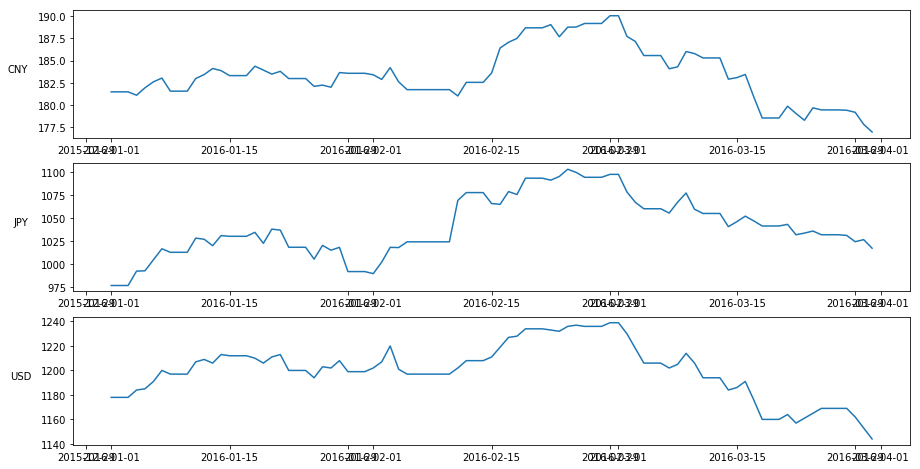

In [14]:
#중국 위안화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프를 생성
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,8))

for(ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313],['CNY','JPY','USD']):
    ax.plot('APPL_DATE','STD_RATE',data=df_raw[df_raw['CURRENCY']==currency])
    ax.set_ylabel(currency, rotation=0, labelpad=20)

앞 뒤 구간의 평균이 다르고 변동이 달라 정상성이 만족되지 않음을 알 수 있다. 따라서 차분이 필요해 보임.

### 3. 시계열 분석

In [15]:
#통화별 데이터 분할
df_CNY = df_raw[df_raw['CURRENCY']=='CNY'].set_index('APPL_DATE')
df_CNY.drop(['CURRENCY', 'USD_CONV_DATE'], axis=1, inplace=True)

df_JPY = df_raw[df_raw['CURRENCY']=='JPY'].set_index('APPL_DATE')
df_JPY.drop(['CURRENCY', 'USD_CONV_DATE'], axis=1, inplace=True)

df_USD = df_raw[df_raw['CURRENCY']=='USD'].set_index('APPL_DATE')
df_USD.drop(['CURRENCY', 'USD_CONV_DATE'], axis=1, inplace=True)

df_CNY.head() #중국 위안화 환율 데이터

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [16]:
#train/test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [17]:
#mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print('shape of train data:{}'.format(df_CNY_train.shape))
print('shape of test data:{}'.format(df_CNY_test.shape))

shape of train data:(82, 1)
shape of test data:(9, 1)


In [18]:
df_CNY_train = df_CNY[df_CNY.index <= '2016-03-22']
df_CNY_test = df_CNY[df_CNY.index > '2016-03-22']
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


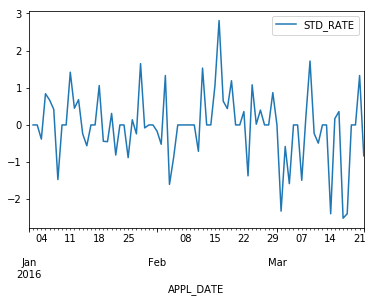

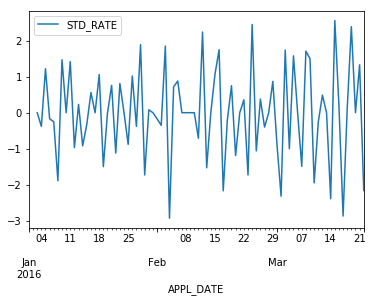

In [19]:
#차분을 통하여 정상성 데이터로 변환
#1차차분
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

#2차차분
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1))+(df_CNY_train.shift(2))
df_CNY_diff2.plot()

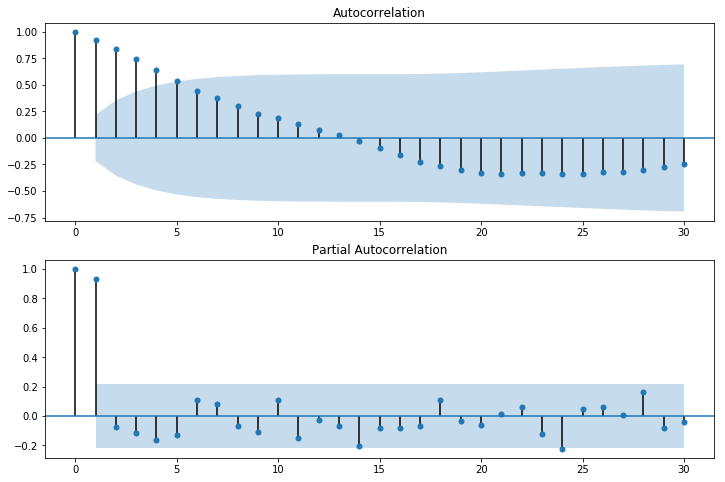

In [20]:
#자기상관 함수 및 부분 자기 상관 함수
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'],lags=lag_size,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'],lags=lag_size, ax=ax2)

ACF는 지속적으로 감소하고 p=13시점에서 양에서 음으로 변하고, PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소한다. 따라서 p=1, q=0 모델이 적당하다고 판단하고 ARMA(1,0) 모델을 적용한다.

In [23]:
#시계열 모델
ts_model_cny = ARIMA(df_CNY_train, order=(1,2,0))

ts_result_cny = ts_model_cny.fit(trend='c',full_output=True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 19 Jul 2019   AIC                            253.025
Time:                        15:51:56   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

ARIMA(1,2,0) 모델의 계수 유의성 확인 !

### 4. 예측 및 결과 해석

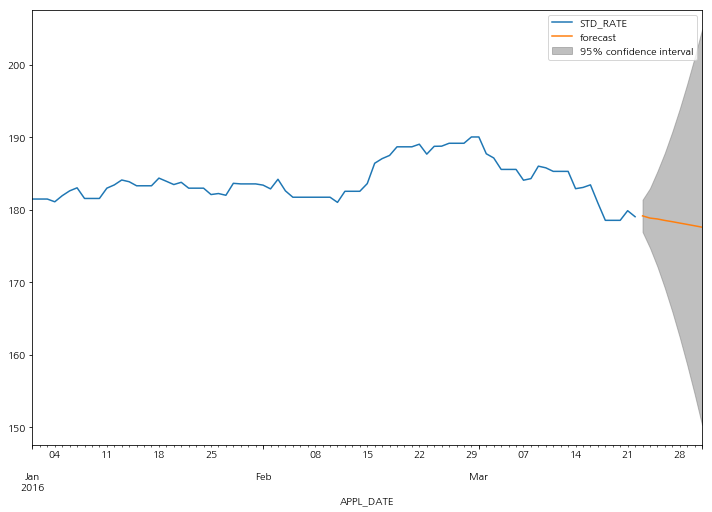

In [25]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax=df_CNY_train.plot(ax = ax)
fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax = ax, plot_insample=False)

2016년 3월 31일까지의 예측값 : 지속적으로 감소할 것으로 예측

예측값에 대한 95% 신뢰구간은 상하 회색 영역으로 표시된다.

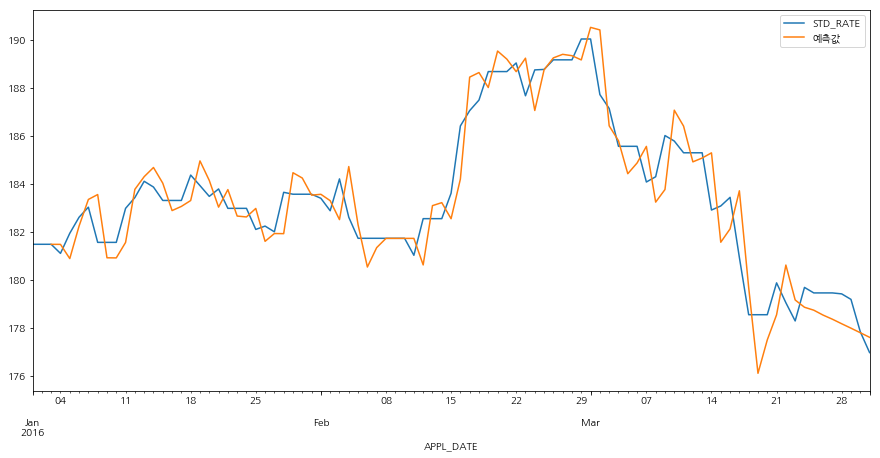

In [28]:
#전체 기간의 실제값, 예측값 확인
start_time = pd.to_datetime('2016-01-03')
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ='levels')
df_merge = df_CNY
df_merge['예측값']=y_pred
df_merge.head()

df_merge.plot(y=['STD_RATE','예측값'],figsize=(15,7))

모델 훈련구간은 실제값 대비 지연현상이 확인되며 예측 구간은 오차가 크다.

## [실습] : 환율
위의 문제에서 생성한 미국 달러 데이터(df_USD)를 이용하여 달러의 변화 추세를 확인하고 시계열 분석을 이용하여 미래의 환율 변동을 확인하시오.
### 1. 데이터 구성하기

In [29]:
df_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


### 2. 변동 추세 확인

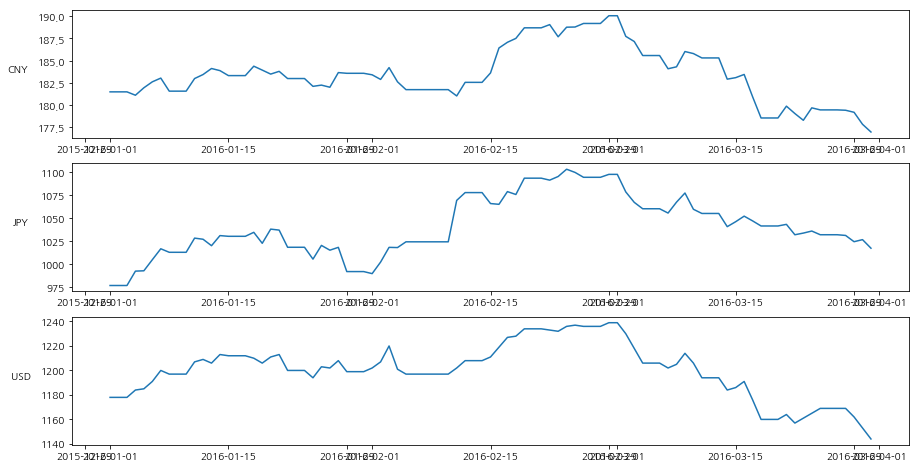

In [32]:
#각각 그래프를 생성
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,8))

for(ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313],['CNY','JPY','USD']):
    ax.plot('APPL_DATE','STD_RATE',data=df_raw[df_raw['CURRENCY']==currency])
    ax.set_ylabel(currency, rotation=0, labelpad=20)

### 3. 시계열 분석

In [35]:
df_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


In [36]:
#train/test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_USD.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [37]:
#mask를 이용한 데이터 분할
df_USD_train = df_USD[mask]
df_USD_test = df_USD[~mask]
print('shape of train data:{}'.format(df_USD_train.shape))
print('shape of test data:{}'.format(df_USD_test.shape))

shape of train data:(82, 1)
shape of test data:(9, 1)


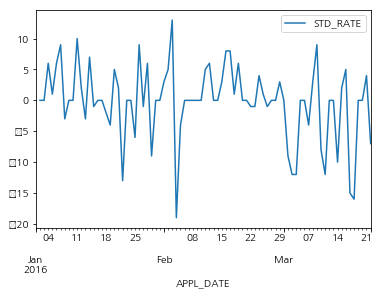

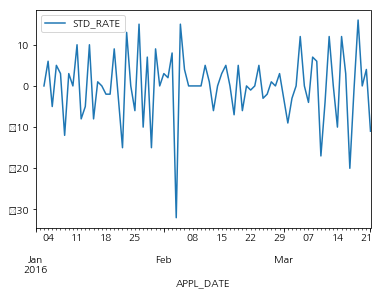

In [38]:
#차분을 통하여 정상성 데이터로 변환
#1차차분
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

#2차차분
df_USD_diff2 = df_USD_train - 2*(df_USD_train.shift(1))+(df_USD_train.shift(2))
df_USD_diff2.plot()

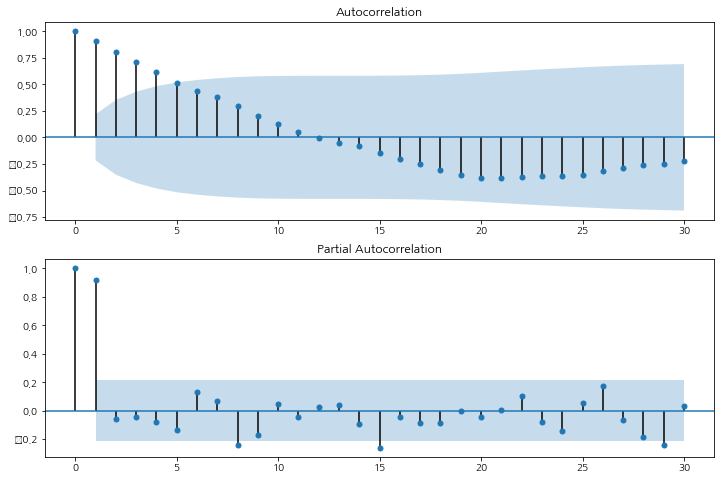

In [39]:
#자기상관 함수 및 부분 자기 상관 함수
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_USD_train['STD_RATE'],lags=lag_size,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_USD_train['STD_RATE'],lags=lag_size, ax=ax2)

ACF는 지속적으로 감소하고 p=12시점에서 양에서 음으로 변하고, PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소한다. 따라서 p=1, q=0 모델이 적당하다고 판단하고 ARMA(1,0) 모델을 적용한다.

In [40]:
#시계열 모델
ts_model_usd = ARIMA(df_USD_train, order=(1,2,0))

ts_result_usd = ts_model_usd.fit(trend='c',full_output=True)
print(ts_result_usd.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.800
Method:                       css-mle   S.D. of innovations              7.502
Date:                Fri, 19 Jul 2019   AIC                            555.601
Time:                        16:07:36   BIC                            562.747
Sample:                    01-03-2016   HQIC                           558.466
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0502      0.612     -0.082      0.935      -1.249       1.148
ar.L1.D2.STD_RATE    -0.3763      0.104     -3.622      0.001      -0.580      -0.173
                        

### 4. 예측 및 결과 해석

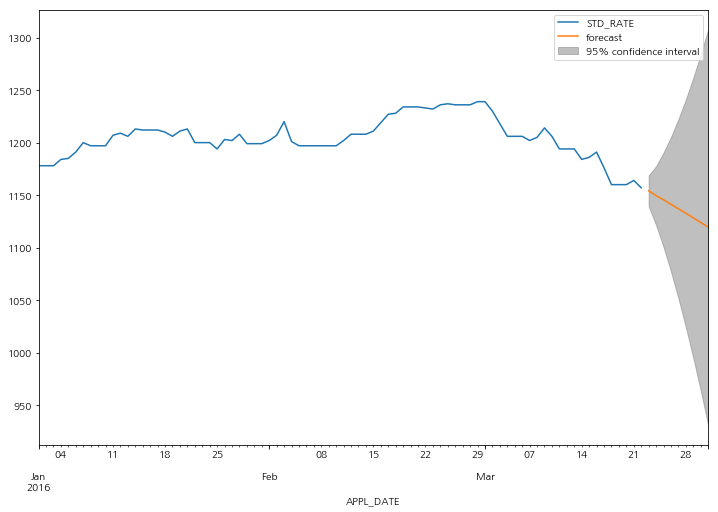

In [41]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax=df_USD_train.plot(ax = ax)
fig = ts_result_usd.plot_predict(start=start_time, end=end_time, ax = ax, plot_insample=False)

2016년 3월 31일까지의 예측값 : 지속적으로 감소할 것으로 예측

예측값에 대한 95% 신뢰구간은 상하 회색 영역으로 표시된다.